## Analysis of the Relationship Between the Number of Communicable Disease Cases in NYC and Temperature Anomalies from 2000-2016
## Fall 2018 'Researching Computing in Earth Sciences' Final Project
### By: Stephanie Stettz 

#### I used the following datasets to conduct this analysis:
####      - NCAR monthly temperature data
####      - Communicable disease records from 2000 to 2016

#### Communicable disease cases are reported to the Bureau of Communicable Disease of the NYC Department of Health and Mental Hygiene (DOHMH).  The dataset can be found on the New York City Open Data Website (https://data.cityofnewyork.us/Health/Communicable-Disease-Surveillance-Data/gff2-veif)


#### I obtained the NOAA NCEP-NCAR CDAS-1 Monthly temperature data from the IRI Data Library (https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/)


In [2]:
# import packages 
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

## Part I: Communicable Disease Dataset


In [3]:
# download and organize disease data
! wget https://data.cityofnewyork.us/api/views/gff2-veif/rows.csv

--2018-11-16 00:19:33--  https://data.cityofnewyork.us/api/views/gff2-veif/rows.csv
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv.1’

rows.csv.1              [ <=>                ] 386.94K  --.-KB/s    in 0.09s   

Last-modified header invalid -- time-stamp ignored.
2018-11-16 00:19:34 (3.98 MB/s) - ‘rows.csv.1’ saved [396230]



### I first renamed certain column for easier access to the data.

In [3]:
# save data in pandas array
diseases = pd.read_csv('rows.csv')
diseases.head()

diseases=diseases.rename(index=str,columns={'Case Count': 'Case_Count',
                                            'Crude Rate per 100,000 Population':'Crude_rate',
                                           'Age-Adjusted Rate per 100,000 Population':'Age_Adj_rate'})
diseases.head()

,Year,Disease,Neighborhood,Case_Count,Crude_rate,Age_Adj_rate
0,2004,Acute hepatitis B,101 Kingsbridge - Riverdale,1,1.1,1.0
1,2004,Acute hepatitis B,102 Northeast Bronx,2,1.1,1.0
2,2004,Acute hepatitis B,103 Fordham - Bronx Park,3,1.2,1.5
3,2004,Acute hepatitis B,104 Pelham - Throgs Neck,9,3.1,3.1
4,2004,Acute hepatitis B,105 Crotona - Tremont,3,1.5,1.6


### Below is a list of the ten communicable diseases recorded in this dataset:

In [4]:
disease_names=diseases.groupby('Disease')
list(disease_names.groups.keys())

['Acute hepatitis B',
 'Chronic hepatitis C',
 'Cryptosporidiosis',
 'Legionellosis',
 'Lyme disease',
 'Malaria',
 'Meningococcal disease, invasive',
 'Salmonellosis',
 'Streptococcus pneumoniae, invasive',
 'West Nile disease']

### From 2000-2016, we can see chronic hepatitis C was the most common communicable disease recorded in New York City (Fig 1a).   2007 had the largest number of recorded communicable disease cases (Fig 1b).

Text(0.5,1,'1b. Number of Cases per Year')

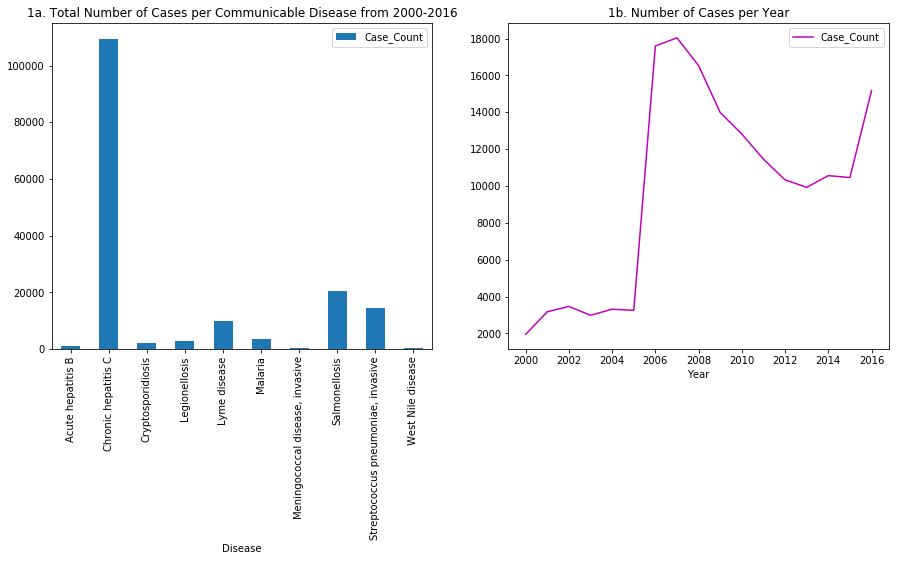

In [5]:
# sort data by disease type 
disease_type = diseases.set_index('Disease')
fig, ax = plt.subplots(ncols=2,figsize=(15,6))
disease_type.groupby('Disease').aggregate({'Case_Count':sum}).plot(ax=ax[0],kind='bar')
ax[0].set_title('1a. Total Number of Cases per Communicable Disease from 2000-2016')
# first plot shows total number of cases over 12 years
diseases.groupby('Year').aggregate({'Case_Count':sum}).plot(ax=ax[1],kind='line',color='m')
ax[1].set_title('1b. Number of Cases per Year')
# second plot shows the total number of cases per year

### I then wanted to group the disease counts by year, to see how many cases of each disease there were per year, which I then plotted in bar plots (Fig 2).

### One issue I had was trying to create subplots so the graphs were next to each other instead of in one large column, so it would be easier to look at. 

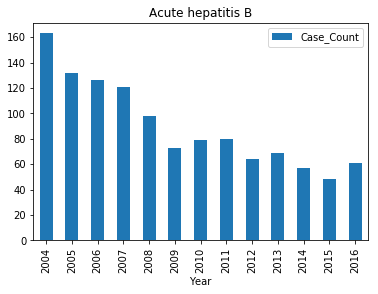

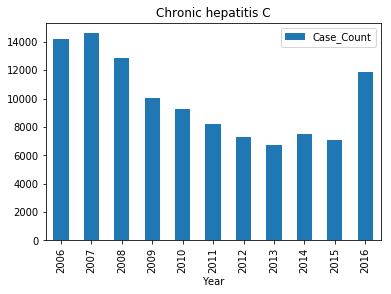

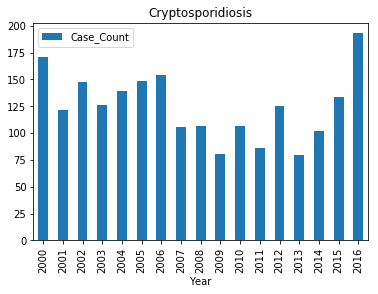

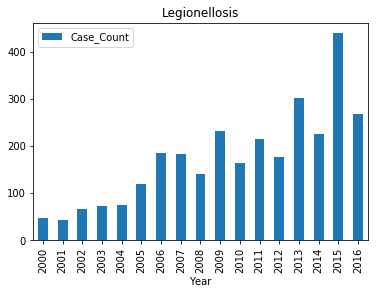

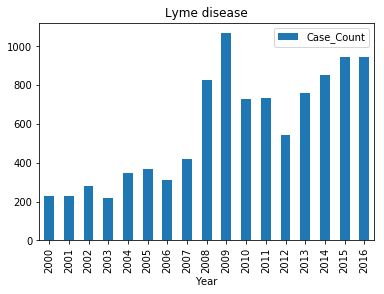

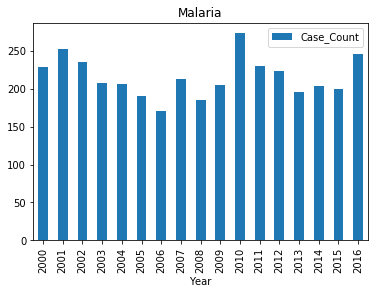

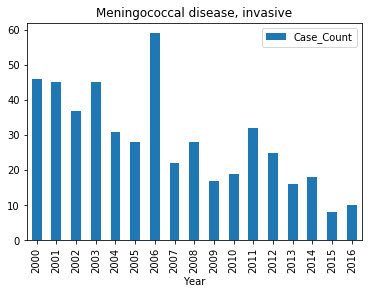

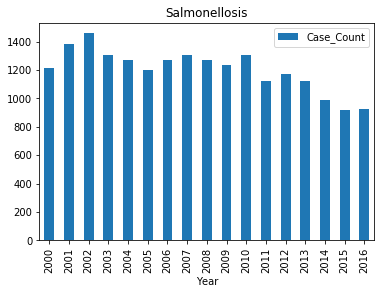

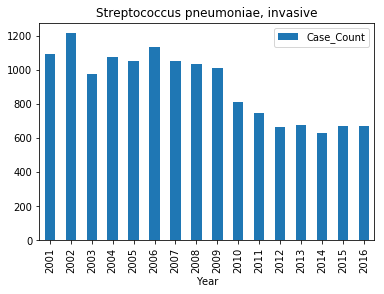

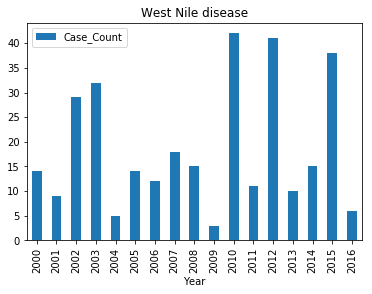

In [16]:
all_names=list(disease_names.groups.keys())
ds_group=diseases.set_index('Disease')
#fig, ax = plt.subplots(ncols=2,nrows=5,figsize=(5,6))
for i in all_names:
    #for k in range(0, len(all_names)):
        ds_group.loc[i].groupby('Year').aggregate({'Case_Count':sum}).plot(kind='bar',title=i)

### Some interesting things to note:
### - Lyme disease and Legionellosis (pneumonia) seem to have an increase in the number of recorded cases as time progresses.
### - Meningococcal meningitis, Strep throat, and Salmonella appear to have a slight decrease in the number of recorded cases over time. 
### - Hepatitis B & C overall seem to have been decreasing over time (except for 2016). However it appears that maybe cases were not recorded (or data is missing) prior to 2004.  
### - Cryptosporidiosis (a diarrheal disease), West Nile and Malaria do not appear to have any sort of trend.  

## Part II: Incorporating Monthly Temperature Data

In [17]:
# import temperature data from IRI library 
# link: 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Diagnostic/.surface/.temp/dods'
dtemp = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Diagnostic/.surface/.temp/dods',decode_times=False)
dtemp

<xarray.Dataset>
Dimensions:  (T: 839, X: 192, Y: 94)
Coordinates:
  * Y        (Y) float32 88.54196 86.65315 84.75323 82.85076 80.94736 ...
  * X        (X) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * T        (T) float32 -131.5 -130.5 -129.5 -128.5 -127.5 -126.5 -125.5 ...
Data variables:
    temp     (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

In [18]:
# fix dataset to read in T as dates 
import cftime
cftime.__version__
# define function to fix calendar issue 
def fix_calendar(dtemp, timevar='T'):
    if dtemp[timevar].attrs['calendar'] == '360':
        dtemp[timevar].attrs['calendar'] = '360_day'
    return dtemp

dtemp = fix_calendar(dtemp)
dtemp = xr.decode_cf(dtemp)
dtemp

<xarray.Dataset>
Dimensions:  (T: 839, X: 192, Y: 94)
Coordinates:
  * Y        (Y) float32 88.54196 86.65315 84.75323 82.85076 80.94736 ...
  * X        (X) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * T        (T) datetime64[ns] 1949-01-16 1949-02-16 1949-03-16 1949-04-16 ...
Data variables:
    temp     (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

### Here I use a running mean to determine the monthly temperature anomaly: 

In [19]:
# calculate running mean 
def remove_time_mean(x):
    return x - x.mean(dim='T')

dt_anom = dtemp.groupby('T.month').apply(remove_time_mean)
dt_anom

<xarray.Dataset>
Dimensions:  (T: 839, X: 192, Y: 94)
Coordinates:
  * Y        (Y) float32 88.54196 86.65315 84.75323 82.85076 80.94736 ...
  * X        (X) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * T        (T) datetime64[ns] 1949-01-16 1949-02-16 1949-03-16 1949-04-16 ...
Data variables:
    temp     (T, Y, X) float32 -7.530716 -7.507324 -7.4995728 -7.49469 ...
    month    (T) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12 ...

### Below I plotted the monthly temperature anomaly, as well as a 1 year resample and a 12-month running mean for New York City (Fig 3). 

In [23]:
dt_anom_resample = dt_anom.resample(T='Y').mean(dim='T')
#dt_anom_resample

In [24]:
dt_anom_rolling = dt_anom.rolling(T=12, center=True).mean()
#dt_anom_rolling

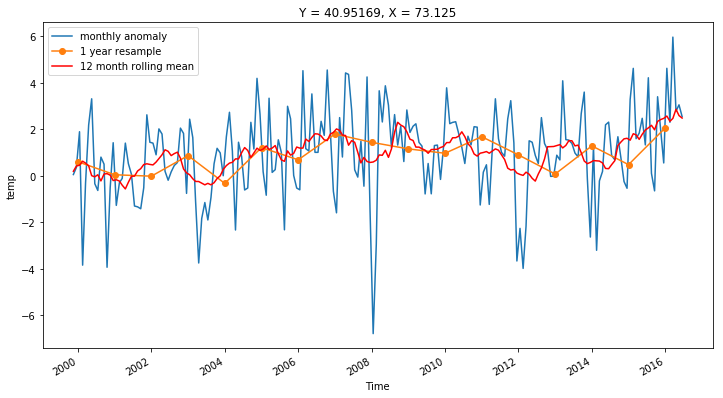

In [25]:
fig, ax = plt.subplots(figsize=(12,6))
dt_anom.temp.isel(X=39, Y=25,T=slice(610,810)).plot(label='monthly anomaly')
dt_anom_resample.temp.isel(X=39, Y=25,T=slice(50,67)).plot(marker='o', label='1 year resample')
dt_anom_rolling.temp.isel(X=39, Y=25,T=slice(610,810)).plot(color='r',label='12 month rolling mean')
plt.legend()

### Since 2007 saw the largest number of communicable disease cases, I wanted to see what the monthly temperature anomalies were for this time period. So I created plots to show summer (July) and Winter (December) monthly temperature anomalies (Fig 4 & 5). 

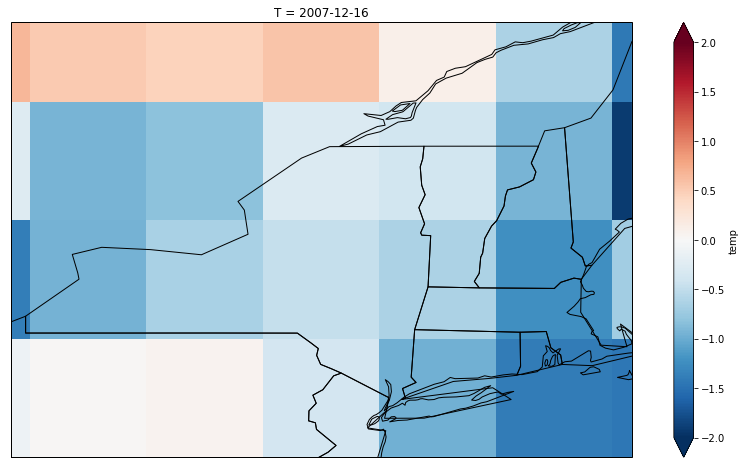

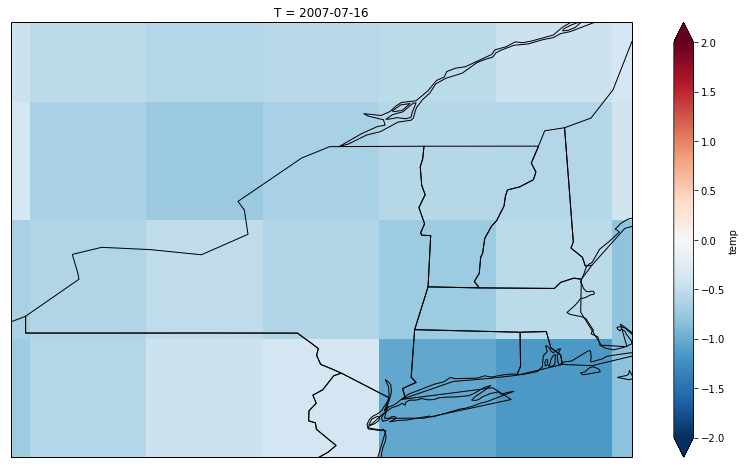

In [26]:
central_lat = 37.5
central_lon = -96
extent = [-80, -70, 40, 47]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
# December 2007 Figure 
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_lon))
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.STATES)
proj = ccrs.PlateCarree() 
# plot temperature data onto map 
dt_anom.temp.sel(T='2007-12-16').plot(ax=ax, transform=proj,cmap='RdBu_r', vmin=-2, vmax=2)
ax.set_extent(extent)
# July 2007 Figure 
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_lon))
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.STATES)
proj = ccrs.PlateCarree() 
# plot temperature data onto map 
dt_anom.temp.sel(T='2007-07-16').plot(ax=ax, transform=proj,cmap='RdBu_r', vmin=-2, vmax=2)
ax.set_extent(extent)

## Part III: Calculating Correlation & Covariance

### I first attempted a simple correlation calculation between the total number of disease cases and the resampled temperature anomaly. Below are the functions I used to do these calculations:

In [14]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [15]:
# set variables of interest to x1 (total disease counts) and y1 (resampled 1 year temperature anomalies)
ds_total=diseases.groupby('Year').aggregate({'Case_Count':sum})
ds_total_xr=ds_total.to_xarray()
x=ds_total_xr.Case_Count
y=dt_anom_resample.temp.isel(X=39, Y=25,T=slice(50,67))

R-squared: 0.3798344245532756 p-value: 0.008423208158496103


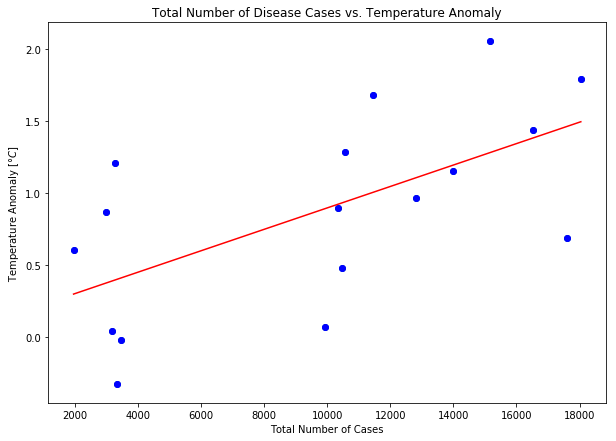

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(x,y)
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,17)
y1=gradient*x1+intercept
plt.plot(x,y,'ob')
plt.plot(x1,y1,'-r')
ax.set_xlabel('Total Number of Cases')
ax.set_ylabel('Temperature Anomaly [$\degree C]$')
ax.set_title('Total Number of Disease Cases vs. Temperature Anomaly')
print('R-squared:', r_value**2, 'p-value:',p_value)

### The R-squared and linear fit seen in the figure (Fig 6) would suggest a positive relationship,and the the p-value is less than 0.05, so we can reject the null hypothesis.

### I then wanted to calculate the correlation between the resampled temperature anomalies and the total number of Lyme disease

R-squared: 0.09147891410592345 p-value: 0.2548681969211506


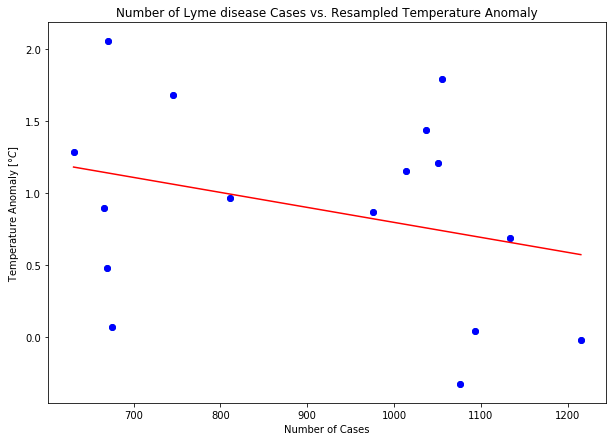

In [55]:
ds_dis = ds_group.loc['Streptococcus pneumoniae, invasive'].groupby('Year').aggregate({'Case_Count':sum})
ds_dis=ds_dis.to_xarray()
x = ds_dis.Case_Count
y=dt_anom_resample.temp.isel(X=39, Y=25,T=slice(51,67))
fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(x,y)
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,17)
y1=gradient*x1+intercept
plt.plot(x,y,'ob')
plt.plot(x1,y1,'-r')
ax.set_xlabel('Number of Cases')
ax.set_ylabel('Temperature Anomaly [$\degree C]$')
ax.set_title('Number of Lyme disease Cases vs. Resampled Temperature Anomaly')
print('R-squared:', r_value**2, 'p-value:',p_value)

In [17]:
## TO DO LIST
# get R2 displayed on graph
# make several maps of temperature anomalies over new york city for different years (lows & highs?)
# attempt to extract counts of just hepatitis C per year to make a linear trend?? 
# do research on why disease counts were so large in 2007???

## Part IV: Conclusions, Caveats & Future Work

#### This analysis is dependent on the number of recorded cases.  It is possible (and most likely) that more cases occurred that were just not recorded.  It is also important to keep in mind that other social factors may account for the changes in the number of cases we see overtime. 